# 3 A Tour of Machine Learning Classifiers Using Scikit-learn

## 3.1 Choosing a classification algorithm
"No Free Lunch" theorem: no single classifier works best across all possible scenarios.

事实上，在处理特定问题过程中我们需要通过比较不同模型的性能表现，根据待处理数据的特征和样本数量，数据中噪声数量，以及类别是线性可分还是线性不可分等。最终，分类器的性能，计算能力和预测能力，很大程度上取决于可以学习到的潜在数据。机器学习的训练过程可以总结为如下的五个主要步骤：
>1. Selection of features
>2. Choosing a performance metric
>3. Choosing a classifier and optimization algorithm
>4. Evaluating the performance of the model
>5. Tuning the algorithm

## 3.2 Training a perceptron via  scikit-learn
为了简单，我们选择scikit-learn库中的Iris flower数据集，方便可视化处理选择其中的两个特征，数据集中样本[n_samples,n_features]=[150,4],n_classes= 3.数据准备阶段：1）将数据集划分为training set（70%） 和 testing set（30%） 2）数据预处理[standardization(zero mean, unit variance),scaling features to a range([0,1])，scaling sparse data, mapping features to uniform distribution，features binarilization，normalization)

In [1]:
#usr! coding=: utf-8
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
import numpy as np

# load dataset
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

# split the dataset to training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 0)

# preprocessing the data
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# create the classification model
ppn = Perceptron(n_iter= 40, eta0= 0.1, random_state= 0)
ppn.fit(X_train_std, y_train)
y_pred = ppn.predict(X_test_std)
print("Misclassificated  samples: %d" %(y_test != y_pred).sum())
print("Accuarcy : %.2f" % accuracy_score(y_test, y_pred))



d:\python35\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
d:\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Misclassificated  samples: 4
Accuarcy : 0.91


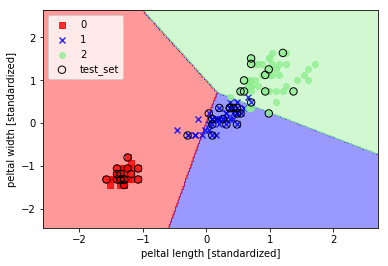

In [2]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# the function ploted the decision regions to split the different class data
def plot_decision_regions(X, y, classifier, test_idx= None, resolution= 0.02):
    # setup maker generator and colormap
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha= 0.4, cmap= cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # plot all samples
    X_test, y_test = X[test_idx, :], y[test_idx]
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x =X[y == cl, 0], y= X[y == cl, 1], alpha = 0.8, c= cmap(idx),
                   marker = markers[idx], label = cl)
    # heighlight test samples
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c= '', alpha = 1.0, linewidth = 1, marker='o', 
                    s= 55, edgecolors= 'black',label = 'test_set')

# plot the decison regions
X_combine_std = np.vstack((X_train_std, X_test_std))
y_combine = np.hstack((y_train, y_test))
plot_decision_regions(X = X_combine_std, y= y_combine, classifier= ppn, test_idx=range(105,150))
plt.xlabel('peltal length [standardized]')
plt.ylabel('peltal width [standardized]')
plt.legend(loc = 'upper left')
plt.show()

## 3.3 Modeling class probabilities via logistic regression

虽然，Perceptron 的规则给我们的分类机器学习算法提供一个非常简单的指引性的介绍，但是它存在一个非常严重的缺陷，对于样本类别不是完全线性可分的时不会收敛，很直观的原因是，在weights不断更新的时每一轮训练过程中至少会有一个错误的分类样本存在。当然，我们可以调节learning rate 和增加epoch的数量，但是需要注意的是Perceptron在该类数据集上永远不会收敛。接下来我们介绍一个在处理线性和二分类问题上简单而有力的算法：**Logistics Regression**
 ## Logistic regression intuition and conditional probabilities
Logistic regression 是一个分类模型，它实现简单，在类别线性可分的问题上表现优异，是工业界应用最广泛的分类算法之一，可以应用在二分类问题上也可以通过OvR的技巧扩展到多类别的分类任务中。首先，为了解释Logistic regression背后的概率模型，引入一个优势率（**odds ratio**），odds表示特定事件的发送概率。odds ratio可以表示为$\frac{p}{1-p}$,p表示positive event发生的概率，positive表示需要预测的事件。我们可以进一步的定义一个对数函数，计算odds ratio的对数值：$logit(p)=\log\frac{p}{1-p}$, 对数函数的输入值范围为0到1，变换后的输出为整个实数域，我们可以将特征值和对数几率（log-odd）表示成如下的线性关系：$$logit(p(y=1|x))= w_0x_0+w_1x_1+\cdots +w_mx_m=\sum_{i=0}^n w_mx_m = {\bf{w}}^T x$$
其中, $p(y=1|x)$ 在给定特征$x$条件特定样本属于类别1的条件概率。

既然我们关注的预测特定样本属于特定类别的概率，这个与对数函数形式恰好相反。我们可以得到一个sigmoid函数：
$$\phi(z) = \frac{1}{1+e^{-z}}$$
其中，$z=w_0+w_1x_1+\cdots +w_mx_m = {\bf{w}}^T x$是权重和样本特征的线性组合。Logistic regression模型中激活函数为sigmoid的计算过程如下图所示：
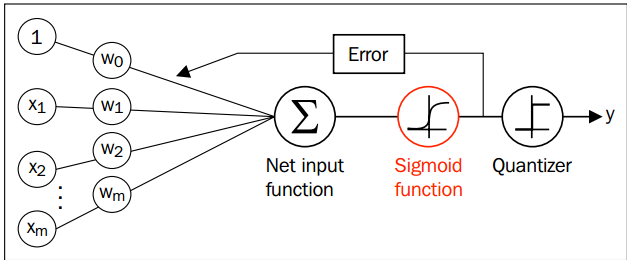

 ## Learning weights of logistic cost function
 定义平方和损失函数如下：
 $$ J(\bf{w}) = \sum_{i}^n \frac{1}{2} (\phi(z^{(i)}) - y^{(i)})^2$$
 为了最小化上述损失函数，我们需要学习权重参数。在建立逻辑回归模型时，我们首先假定数据集中样本相互独立，接着定义一个likelihood function L,公式如下：$$ L({\bf{w}})=P({\bf{y|x;w}})=\prod_{i=1}^n P(y^{(i)}|x^{(i)};{\bf{w}})=(\phi(z^{(i)}))^{y^{(i)}} (1-\phi(z^{(i)}))^{1-y^{(i)}}$$
 对数似然方程如下：
 $$l({\bf {w}})=\log L({\bf w})=\sum_{i=1}^n y^{(i)}\log(\phi(z^{(i)})) + (1-y^{(i)})\log(1-\phi(z^{(i)}))$$
 we can convert the above formula to the the follow equation $J({\bf w})$ and use an optimization algorithm to obtain it's maximum value.
$$J({\bf {w}})=-\sum_{i=1}^n y^{(i)}\log(\phi(z^{(i)})) - (1-y^{(i)})\log(1-\phi(z^{(i)}))$$
Looking at the preceding equation,we can see that the first term becomes zero if $y=0$,and the second term becomes zero if $y=1$,respectively:
$$ J(\phi(z),y;{\bf w})= \begin{cases} -\log(\phi(z)), & \text{if $\; y=1$} \\ -\log(1-\phi(z)). & \text{if $\; y=0$} \end{cases}$$
In the figure below,we can see that if the prediction is wrong, the cost goes towards infinity.The moral is that we penalize wrong predictions with an increasingly larger cost
目标函数求导如下：
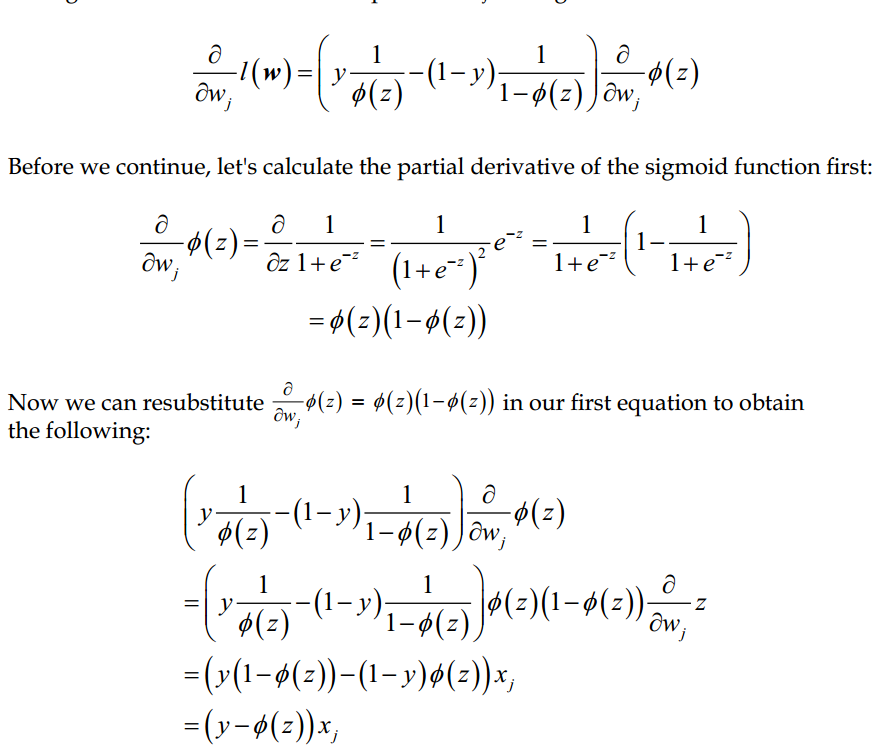
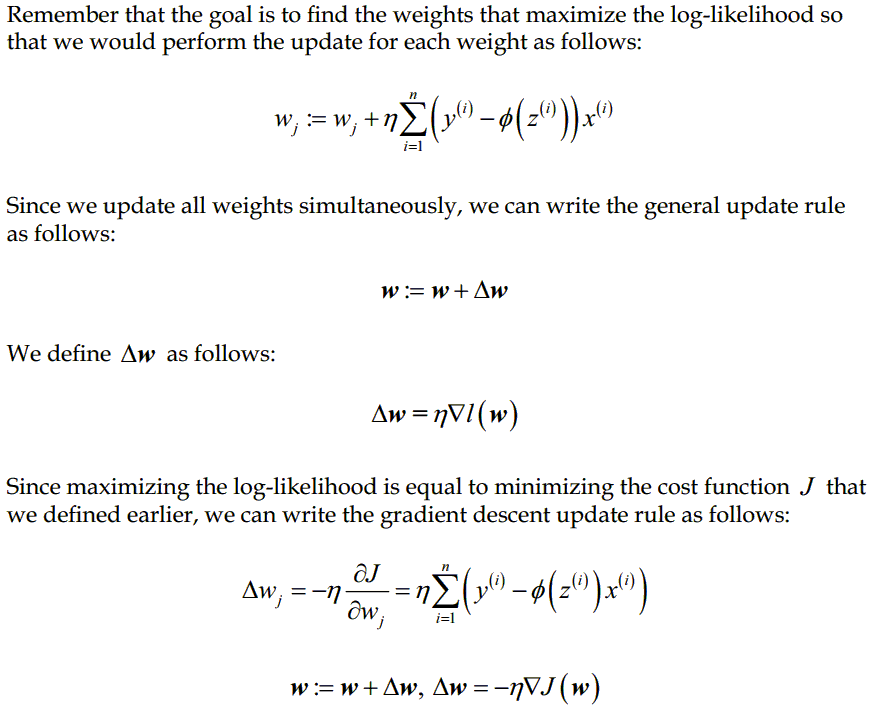

## Tacking overfitting via regularization
overfitting是机器学习中常见问题，主要表现是模型在训练集上的性能表现良好，但在测试集上性能较差，即泛化性能较差。此时模型的统计学表征为有较高的方差（high variance），在给定的潜在数据集上学习的参数太多导致模型复杂度太高。同样的，underfiting（high bias）是模型的复杂度较低，不足以学习到训练数据集中的特征模式，在训练集和测试集上性能表现都比较差。下图直观的描述了不同的decision boundary导致模型的过拟合和欠拟合：
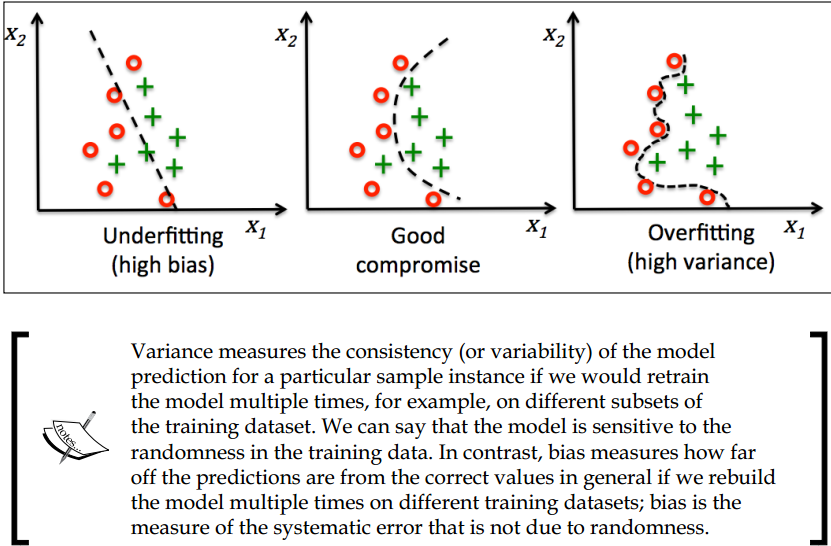
正则化（regularization）是平衡方差和偏差的一种方法，它在处理共线性（特征之间有高度相关性）和过滤数据中的噪声问题上很有用，如此可以达到阻止过拟合的目的。常用的正则化式**L2 regularization**(也称为L2压缩，权重衰减），表达式如下：$$ \frac{\lambda}{2} ||w||^2 = \frac{\lambda}{2} \sum_{j=1}^n w_{j}^2$$
引入正则化项后的Logistic regression的目标函数方程如下：
$$J(\bf{w})=[-\sum_{i=1}^n(y^{(i)}\log(\phi(z^{(i)}) + (1-y^{(i)})\log(1- \phi(z^{(i)})))] + \frac{\lambda}{2}||w||^2$$
通过调节参数$\lambda$,我们可以控制在拟合训练数据的过程中保持权重为较小的值，增加$\lambda$可以增强正则化强度。在scikit-learn lib 中，SVM的实现过程中定义的参数$C= \frac{1}{\lambda}$,通常大部分机器学习库中正则化参数用$C$表示。则上述目标函数表示为下式：
$$J(\bf{w})= C[-\sum_{i=1}^n(y^{(i)}\log(\phi(z^{(i)}) + (1-y^{(i)})\log(1- \phi(z^{(i)})))] + \frac{1}{2}||w||^2$$

Accuracy: 0.98
Predict probability of class label: 
 [[0.000 0.063 0.937]
 [0.001 0.999 0.000]
 [0.817 0.183 0.000]]


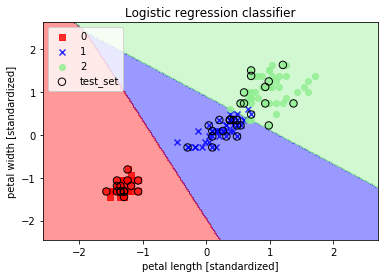

In [3]:
#logistic regression classification
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C= 1000.0, random_state= 0)
lr.fit(X_train_std, y_train)
y_pred = lr.predict(X_test_std)
print('Accuracy: %.2f' % ((y_test == y_pred).sum()/len(y_test)))
# show the predicted probabilities of test samples.
#np.set_printoptions(suppress = True)
np.set_printoptions(formatter= {'float': '{:0.3f}'.format})
print('Predict probability of class label:','\n' ,lr.predict_proba(X_test_std[0:3,:]))

plt.figure(2)
plot_decision_regions(X= X_combine_std, y = y_combine, classifier= lr,
                     test_idx= range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc= 'upper left')
plt.title('Logistic regression classifier')
plt.show()

## 3.4 Maximun margin classification with support vector machine
SVM是一种应用非常广泛的学习算法，可以看作是对Perceptron的扩展，使用Perceptron算法时，我们需要最小化错误分类的错误率，而在SVM中我们优化的目标是最大化间隔（margin），间隔的定义是距离超平面最近的样本点与分割超平面（decision boundary）的距离，距离超平面最近的样本点称为支持向量点。该过程的描述见下图：
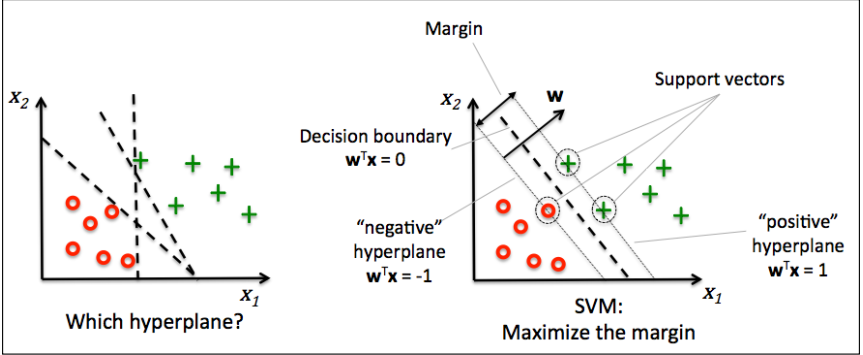

 ## Maximum margin intuition
 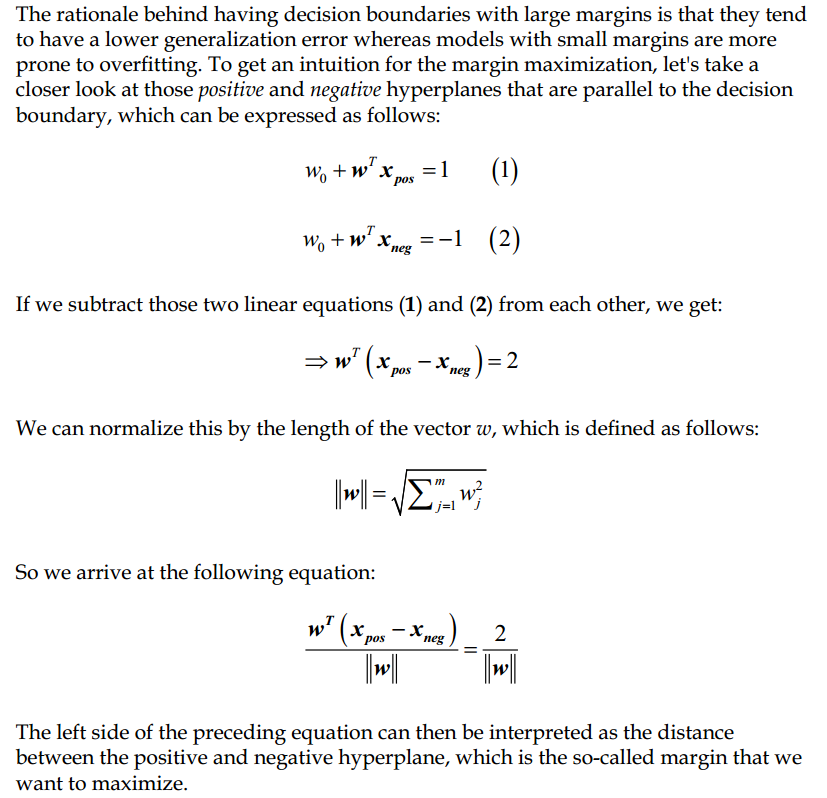
 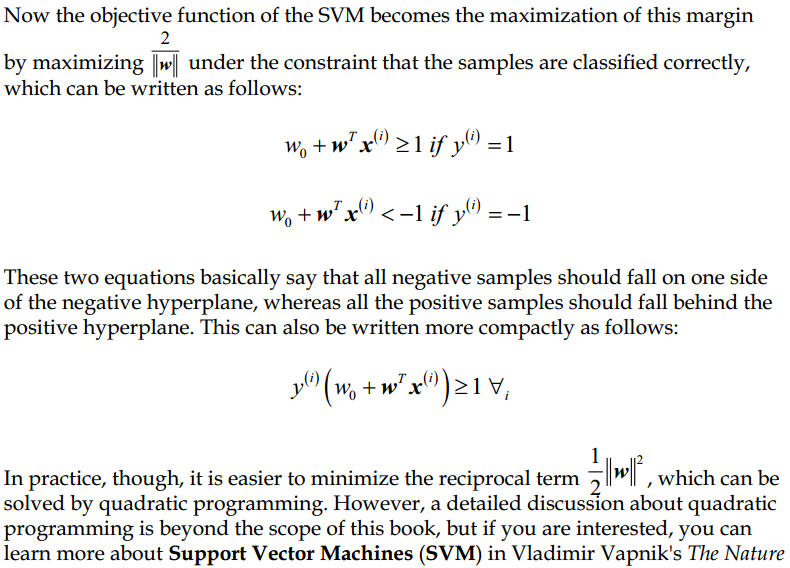
 ## Dealing with the nonlinearly separable case using slack variables
 在处理轻微的线性不可分数据的时候引入松弛变量（$\xi$）可以在有适当的损失惩罚的情况下，使得存在错误分类的时候达到优化收敛。引入松弛变量的分类又称为软间隔分类（soft-margin classification）。
 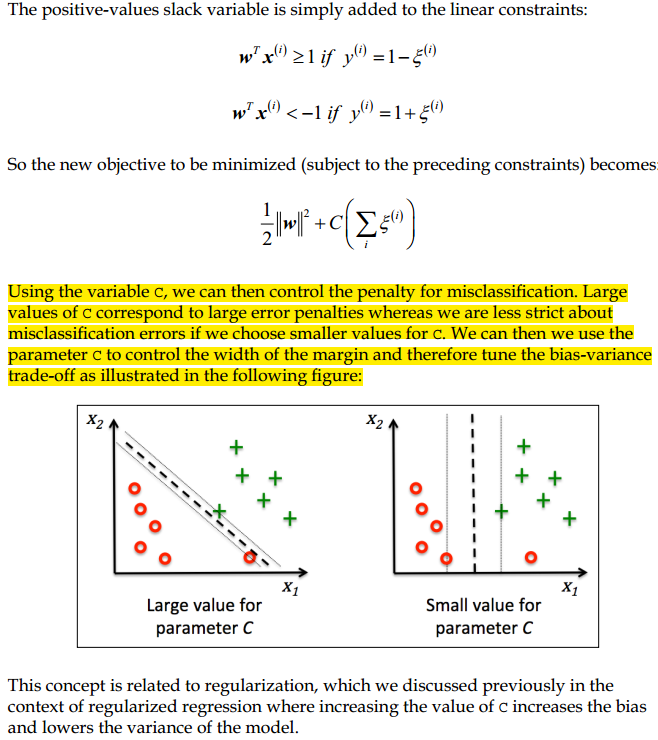
 SVM与Logistic regression的比较：
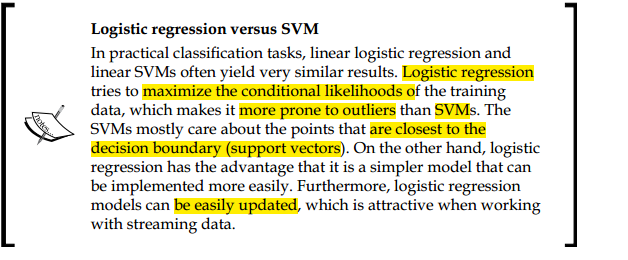
 ## Solving nonlinear problems using a kernel SVM
 kernel SVM的核心思想是在处理线性不可分的数据时，通过一个映射函数（mapping function $\phi(\cdot)$）将原始特征的非线性组合投影到高维空间，使其变得线性可分。一个简单例子如下图所示：
 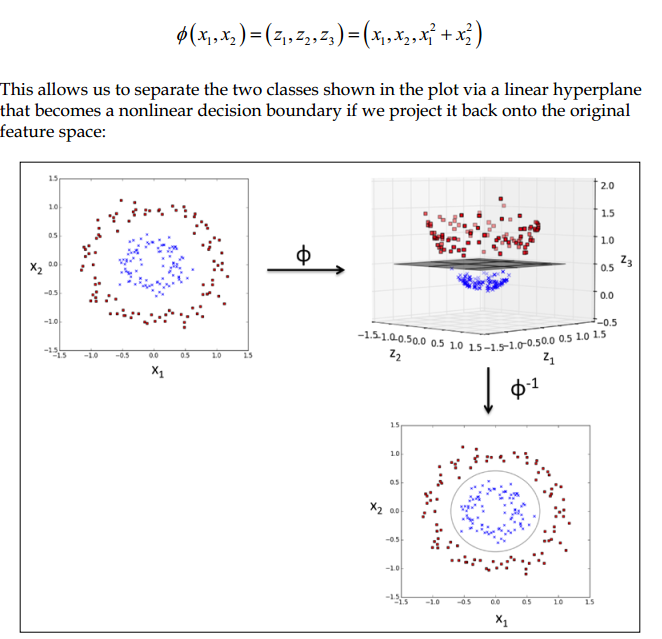
 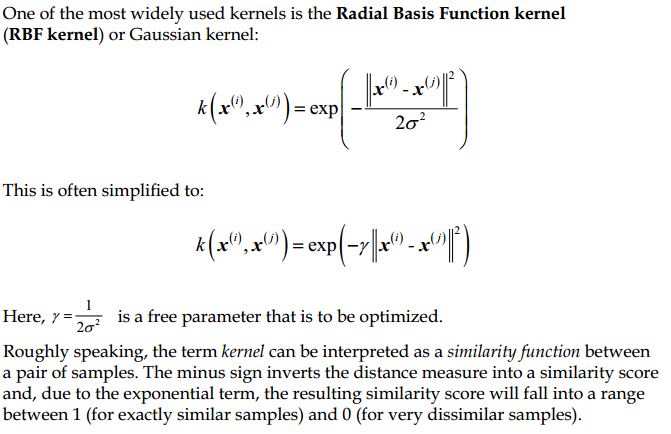
 

svm classifciation accuracy: 0.98


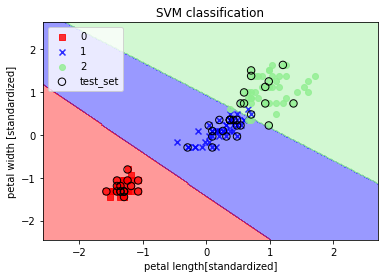

kernel SVM classifier accuracy: 1.00


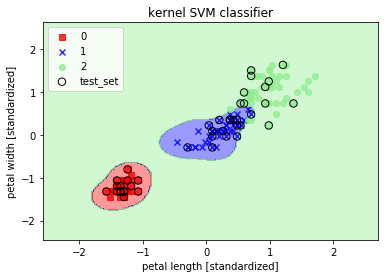

kernel SVM classifier accuracy: 0.98


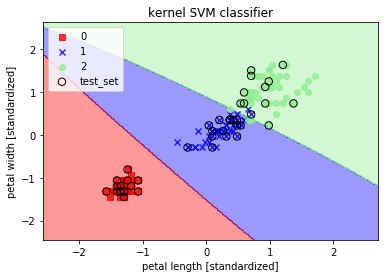

In [4]:
# train SVM model to classify the different flowers in iris dataset
from sklearn.svm import SVC
# using linear SVM model to classify
svm = SVC(kernel='linear', C= 1.0, random_state= 0)
svm.fit(X_train_std, y_train)
y_pred = svm.predict(X_test_std)
print('svm classifciation accuracy: %.2f'% accuracy_score(y_test, y_pred))
plot_decision_regions(X_combine_std,y_combine, classifier=svm, test_idx=range(105, 150))
plt.figure(1)
plt.xlabel("petal length[standardized]")
plt.ylabel("petal width [standardized]")
plt.legend(loc = "upper left")
plt.title("SVM classification")
plt.show()

#using nonlinear kernel SVM model to classify
svm = SVC(kernel= 'rbf', gamma=10.0, C= 10, random_state=0)
svm.fit(X_train_std, y_train)
y_pred = svm.predict(X_test_std)
print('kernel SVM classifier accuracy: %.2f'% accuracy_score(y_test, y_pred))
plt.figure(2)
plot_decision_regions(X_combine_std, y_combine, classifier=svm, test_idx=range(105,150))
plt.xlabel("petal length [standardized]")
plt.ylabel("petal width [standardized]")
plt.legend(loc= "upper left")
plt.title("kernel SVM classifier")
plt.show()

svm = SVC(kernel= 'rbf', gamma=0.1, C= 1.0, random_state=0)
svm.fit(X_train_std, y_train)
y_pred = svm.predict(X_test_std)
print('kernel SVM classifier accuracy: %.2f'% accuracy_score(y_test, y_pred))
plt.figure(3)
plot_decision_regions(X_combine_std, y_combine, classifier=svm, test_idx=range(105,150))
plt.xlabel("petal length [standardized]")
plt.ylabel("petal width [standardized]")
plt.legend(loc= "upper left")
plt.title("kernel SVM classifier")
plt.show()

## 3.5 Decision tree learning
Decision tree classifier具有很好可解释性，直观的理解模型通过对一系列问题的判断来分解训练数据，并推断出数据所属的类别。Decision algorithm的计算过程，首先利用信息增益（information gain：IG）最大化的准则从树的根节点开始进行划分，重复这种划分过程直至得到纯净的叶节点。这样意味着每个节点的样本都属于同一类别。实际上我们会得到包含大量节点的非常深的树，这样很容易导致过拟合。通常我们需要有一个最大树深的限制来对树进行一定程度的裁剪来防止过拟合。
 ## Maximum information gain
 为了在信息量最大的特征节点处做划分，需要定义一个目标函数，在每次划分时最大化信息增益，目标函数的定义式如下：
 $$IG(D_p,f) = I(D_p)-\sum_{j=1}^m\frac{N_j}{N_p}I(D_j)$$
 其中，$f$是执行划分的特征，$D_p, D_j$分别是数据集中父节点和$j-th$孩子节点，$I$是不确定性的度量，$N_p, N_j$分别是父节点和$j-th$节点处样本的数量。信息增益简单的理解就是父节点的不确定性度量和孩子节点不确定性度量的之和的差异，孩子节点处的不确定性度量越小，信息增益越大。为了简单和降低组合搜索空间，通在实现过程中常用binary decision trees。即每个父节点只有两个孩子节点。目标函数变为：
 $$IG(D_p,f) = I(D_p) - \frac{N_{left}}{N_p}I(D_{left}) -\frac{N_{right}}{N_p}I(D_{right})$$
 三种常用的不确定性度量或者是划分准则, **Gini index ($I_G$)**,**entropy($I_H$)**, **classification error($I_E$)**.
 
 信息熵（entropy）的定义式:
 $$ I_H(t) = - \sum_{i=1}^c p(i|t)\log_{2}{p(i|t)}$$
 其中，$p(i|t)$是在节点t属于类别c的样本所占的比例。如果在一个节点处所有的样本都属于同一个类别，则信息熵为0，而如果样本类别为均匀分布，则信息熵最大。举个例子，设置类别为2，当$p(i=1|t)=1, p(i=0|t)=0$,信息熵为0，当$p(i=1|t)=0.5, p(i=0|t)=0.5$,信息熵为1.因此，信息熵的准则是试图最大化树中的互信息（mutual information）。
 
 基尼索引（Gini index）可以直观的理解为最小化错误分类概率的一个准则，定义式：
 $$I_G(t) = \sum_{i=1}^c p(i|t)(1-p(i|t) = 1- \sum_{i=1}^c p(i|t)^2$$
 与信息熵类似，如果类别充分的混杂，基尼索引值最大。当类别值c=2时，$1-\sum{i=1}^c 0.5^2=0.5$
 
 分类错误（classification error），定义式：
 $$ I_E(t) = 1-max({p(i|t)})$$
 这个准则在剪枝过程中非常有用，但不推荐在树的生成过程中使用，应为它对节点处类别概率的改变不敏感。

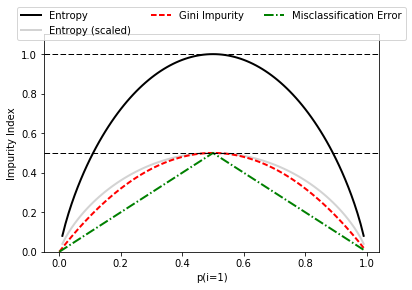

In [5]:
import matplotlib.pyplot as plt
import numpy as np
def gini(p):
    return (p)*(1 - (p)) + (1 - p)*(1 - (1-p))
def entropy(p):
    return - p*np.log2(p) - (1 - p)*np.log2((1 - p))
def error(p):
    return 1 - np.max([p, 1 - p])
x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e*0.5 if e else None for e in ent]
err = [error(i) for i in x]
fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err],
                          ['Entropy', 'Entropy (scaled)','Gini Impurity','Misclassification Error'], 
                          ['-', '-', '--', '-.'], ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),ncol=3, fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.show()

tree classifier's accuracy: 0.98


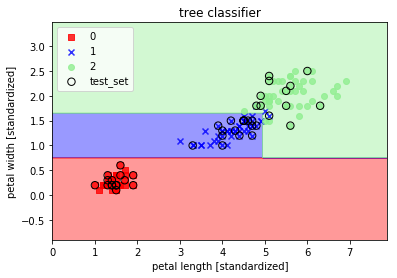

In [6]:
 # train a decision tree model for classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
# train model
tree = DecisionTreeClassifier(criterion='entropy', max_depth= 3, random_state=0)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print("tree classifier's accuracy: %.2f"% accuracy_score(y_test, y_pred))

X_combine = np.vstack((X_train, X_test))
plot_decision_regions(X_combine, y_combine, classifier=tree, test_idx=range(105,150))
plt.xlabel("petal length [standardized]")
plt.ylabel("petal width [standardized]")
plt.legend(loc= "upper left")
plt.title("tree classifier")
plt.show()
# output the tree graphviz
export_graphviz(tree, out_file= 'tree.dot', feature_names= ['petal length', 'petal width'])

## 3.6 Combining weak to strong learners via random forests
Random forest有分类性能，可扩展性和易用性比较好。随机森林可以直观的看作是集成了很多个决策树。集成学习的基本思想是通过组合多个弱学习器来构建一个鲁棒的模型（强学习器），可以得到一个很好泛化误差，避免过拟合。随机森林算法可以简述为如下四个步骤：

* 1.抽取大小为n的随机自举样本（bootstrap sample）（随机在训练集中选择n个样本作为替换）
* 2.从自举样本中生成决策树。在每一个节点处：
  * 1.随机选择d个特征，不需要替换
  * 2.根据目标函数提供的最优划分节点的特征来划分节点。例如，最大信息熵。
* 3.重复步骤1和2 k次。
* 4.汇总每棵树的预测用多数投票的机制来分配类别标签。

在训练单棵树的过程中对步骤2做了轻微的调整，我们只考虑特征的部分随机子集，而不是评估所有的特征之后选取最优的划分节点。虽然随机森林不能提供像决策树那样的可解释性，但是它有一个很大优势就是不用的担心如何选择一个好的超参数，因为集成模型对单个决策树的噪声有很强鲁棒性，我们不需要对随机森林做裁剪。我们唯一需要关心的参数是随机森林的树的个数（k 步骤3）。通常，树的个数越多随机森林分类器的性能越好，但伴随着计算代价的增加。

在随机森林算法的使用过程中，我们可以选取合适的n（n_bootstrap_samples）来控制随机森林模型的偏差和方差的平衡，当n取值较大时在训练样本集中抽取样本的随机性降低了，这样会到导致模型的过拟合。减小n可降低一点模型性能的同时避免过拟合。在scikit-learn中RandomForestClassifier的n取值为原始训练集样本个数。对于每个划分节点处的特征数量d(subset of features)，一般默认取值为$d=\sqrt{m}$,m是训练样本集的特征的个数。

tree classifier's accuracy: 0.93


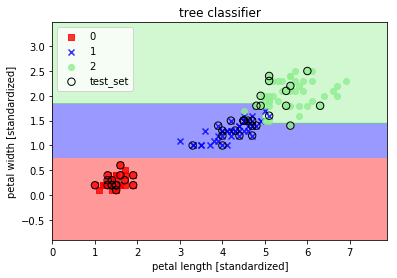

In [7]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='entropy',n_estimators= 10, random_state= 0, n_jobs= 2)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print("tree classifier's accuracy: %.2f"% accuracy_score(y_test, y_pred))

plot_decision_regions(X_combine, y_combine, classifier=forest, test_idx=range(105,150))
plt.xlabel("petal length [standardized]")
plt.ylabel("petal width [standardized]")
plt.legend(loc= "upper left")
plt.title("tree classifier")
plt.show()
# output the tree graphviz
export_graphviz(tree, out_file= 'tree.dot', feature_names= ['petal length', 'petal width'])

In [52]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble.forest:

class RandomForestClassifier(ForestClassifier)
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and use averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is always the same as the original
 |  input sample size but the samples are drawn with replacement if
 |  `bootstrap=True` (default).
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------
 |  n_estimators : integer, optional (default=10)
 |      The number of trees in the forest.
 |  
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |      Note: this parameter is tree-specific.
 |  
 |  max_features : int, fl

In [43]:
print(forest.classes_,forest.n_classes_, forest.n_features_,forest.n_outputs_ )

[0 1 2] 3 2 1


## 3.7 K-nearest neighbors - a lazy learning algorithm
KNN与其它监督的机器学习算法不同，作为一个典型的懒学习器，它不是从训练数据集中学习具有判别性的函数，而是记录训练数据。
> 参数与非参数模型

>参数模型：通过从训练数据集中评估的参数学习一个函数，在不需要原始训练集的情况下对新数据进行分类。

>典型的参数模型有：Perceptron，Logistic regression，Linear SVM。

>非参数模型：不能通过固定参数集合来描述模型，参数量随着训练集合增加而增加。

>典型的非参数模型有：Decision tree，Random forest，kernel SVM，KNN。

KNN算法可以简单直接的概括为如下三个步骤：
* 1.选择近邻个数k和距离度量。
* 2.寻找待分类样本的k个邻居。
* 3.用多数表决的方式给样本分配类别标签
![knn.png](attachment:knn.png)
这种基于记忆方法的优势是当我们收集到新的数据集时分类器可以立即做出调整，而缺点是对新样本做分类的计算复杂度会随着训练集中样本数量呈线性增长，除非数据集的特征维度非常低和算法实现利用了非常高效的数据结构（KD-tree）。此外，KNN不需要训练过程，对新样本的分类依赖于原始数据集，所以不合适处理大规模的数据，因为存储空间是一个很大的挑战。

tree classifier's accuracy: 1.00


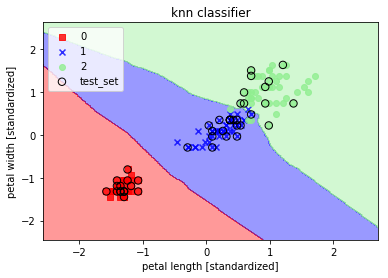

In [67]:
# using KNN for classification
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors= 5, p=2, metric= 'minkowski')
knn.fit(X_train_std, y_train)
y_pred = knn.predict(X_test_std)
print("tree classifier's accuracy: %.2f"% accuracy_score(y_test, y_pred))

plot_decision_regions(X_combine_std, y_combine, classifier=knn, test_idx=range(105,150))
plt.xlabel("petal length [standardized]")
plt.ylabel("petal width [standardized]")
plt.legend(loc= "upper left")
plt.title("knn classifier")
plt.show()


## Summary
* 1.Logistic regression 通过SGD可以进行online learning，而且可以预测特定事件的概率。
* 2.SVM 是非常优秀的线性模型，可以通过kernel trick扩展为非线性模型，要获得比较好预测效果需要对超参数（C，gama，etc）进行fine tune。
* 3.Decision tree 模型简单而且可解释性强，为了防止过拟合需要进行剪枝处理。
* 4.Random forest 作为集成模型的一种，不需要对参数进行tuning，也不像Decision tree容易过拟合，解决实际问题很实用。
* 5.KNN 作为懒学习器也是分类问题的一种选择，不要任何的模型训练就可以预测，但是预测过程计算代价太大。